In [1]:
from manifold_flow.flows import ManifoldFlow
from manifold_flow import transforms, training
from manifold_flow.architectures.vector_transforms import create_vector_transform

import numpy as np
import torch
import logging
from math import sqrt
import matplotlib.pyplot as plt

# Set up Python's logging system to show INFO logs for M-Flow code
logging.basicConfig(
    format="%(asctime)-5.5s %(message)s",
    datefmt="%H:%M",
    level=logging.INFO,
)

# Ensure that logging output of all other modules (e.g. matplotlib) is shown
# only if it is at least a WARNING, not just an INFO.
for key in logging.Logger.manager.loggerDict:
    if "experiments" not in key and "manifold_flow" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)

In [2]:
# Define M-Flow model
params = {
    "batch_size"         : 512,
    "n_flow_steps"       : 16,   # Depth (#layers)  of the "outer transform"
    "hidden_features"    : 100,  # Width (#neurons) of the "outer transform"
    "n_transform_blocks" : 2     # ???
}
mflow = ManifoldFlow(
    data_dim=2,
    latent_dim=1,
    inner_transform=transforms.ConditionalAffineScalarTransform(features=1),
    outer_transform=create_vector_transform(
        dim                  = 2,
        flow_steps           = params["n_flow_steps"],
        hidden_features      = params["hidden_features"],
        num_transform_blocks = params["n_transform_blocks"]
    )
)

mflow.load_state_dict(torch.load("../data/models/spiral_mflow_nrotations_1.2_successful.pt"))

18:06 Model has 0.7 M parameters (0.7 M trainable) with an estimated size of 2.7 MB
18:06   Outer transform: 0.7 M parameters
18:06   Inner transform: 0.0 M parameters


<All keys matched successfully>

In [3]:
mflow.eval()
samples = mflow.sample(n=10_000).detach().numpy()

In [4]:
def generate_grid_tensor(
        n_points_per_axis: int,
        min_val:           float,
        max_val:           float
    ) -> torch.Tensor:
    linspace    = torch.linspace(min_val, max_val, n_points_per_axis)
    x, y        = torch.meshgrid(linspace, linspace, indexing="ij")
    grid_points = torch.stack([x.flatten(), y.flatten()], dim=-1)
    return grid_points

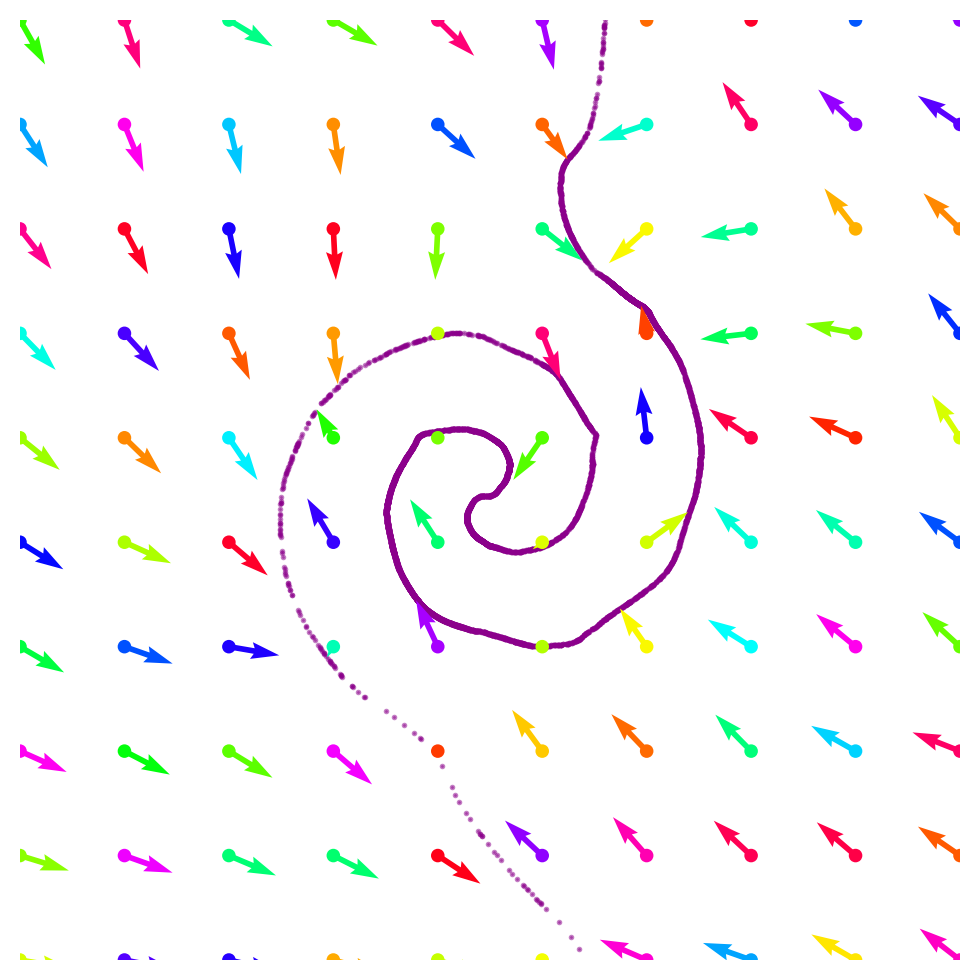

In [5]:
# Generate random colours for the sample points
n_samples     = 100
random_values = torch.rand(n_samples)
colours       = plt.colormaps["hsv"](random_values)[:, :3]

# Generate random samples and project them to the manifold
# X        = torch.randn(n_samples, 2)
X        = generate_grid_tensor(int(sqrt(n_samples)), -2.3, 2.3)
X_latent = mflow.encode(X)
X_proj   = mflow.decode(X_latent).detach().numpy()

# Define arrays used for plotting the projection vectors via `plt.quiver` 
x_start, y_start = X.T.numpy()
x_end,   y_end   = X_proj.T
dx               = x_end - x_start
dy               = y_end - y_start

# Normalise vectors for visual clarity (optional)
norm = np.linalg.norm(np.array([dx, dy]), axis=0) * 4
dx  /= np.where(norm > 1, norm, 1)  # Normalise vectors with norm > 1
dy  /= np.where(norm > 1, norm, 1)  # Normalise vectors with norm > 1

# Plotting
plt.figure(figsize=(5, 5), dpi=200)
plt.scatter(*samples.T, s=1,  alpha=0.5, c="darkmagenta")
plt.scatter(*X.T,       s=15, alpha=1,   c=colours)

# Plot projection vectors
plt.quiver(x_start, y_start, dx, dy, scale_units="xy", scale=1, color=colours)

plt.gca().set_aspect("equal", adjustable="box")
plt.axis("off")
plt.xlim(-2.3, 2.3)
plt.ylim(-2.3, 2.3)
plt.tight_layout()